In [720]:
import pandas as pd
import glob
import numpy as numpy
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error

import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Read in data


In [423]:
dict_of_stocks_and_dfs = {}
for file_ in glob.glob('../data/updated_historical_stock_data/*.csv'):
    stock_name = file_.rsplit("/")[-1].split('_')[0].lower() 
    print(f"Reading in {stock_name}")
    dict_of_stocks_and_dfs[stock_name] = pd.read_csv(f"{file_}")


Reading in pnr
Reading in bac
Reading in ni
Reading in vno
Reading in ual
Reading in efx
Reading in ph
Reading in rop
Reading in are
Reading in pg
Reading in pvh
Reading in lb
Reading in cern
Reading in peg
Reading in adbe
Reading in emr
Reading in ce
Reading in eqix
Reading in rost
Reading in so


In [424]:
# key is company value is df of data
dict_of_stocks_and_dfs.keys()

dict_keys(['pnr', 'bac', 'ni', 'vno', 'ual', 'efx', 'ph', 'rop', 'are', 'pg', 'pvh', 'lb', 'cern', 'peg', 'adbe', 'emr', 'ce', 'eqix', 'rost', 'so'])

# Create correlation & variance features
- Daily, weekly, 30-days, 90-days, 180-days, 365-days

In [425]:

# here the date is not the index, yet
first_stock_df = dict_of_stocks_and_dfs['ph'].loc[ dict_of_stocks_and_dfs['ph'].date.isin(dict_of_stocks_and_dfs['emr'].date), :]

In [426]:
np.var(first_stock_df.close)

2629.342599254268

In [427]:
dict_of_stocks_and_dfs['ph'][dict_of_stocks_and_dfs['ph'].date == '2017-01-02']

,date,open,high,low,close,volume


In [428]:
dict_of_stocks_and_dfs['ph'][dict_of_stocks_and_dfs['ph'].date == '2017-01-03']

,date,open,high,low,close,volume
0,2017-01-03,142.2,144.25,140.83,142.55,1115090


In [429]:
dict_of_stocks_and_dfs['ph'][dict_of_stocks_and_dfs['ph'].date == '2017-01-04']

,date,open,high,low,close,volume
1,2017-01-04,142.5,143.2,141.9,142.64,637928


In [430]:
dict_of_stocks_and_dfs['ph'][dict_of_stocks_and_dfs['ph'].date == '2017-01-05']

,date,open,high,low,close,volume
2,2017-01-05,142.35,142.67,139.92,141.37,557915


In [431]:
dict_of_stocks_and_dfs['ph'][dict_of_stocks_and_dfs['ph'].date == '2017-01-06']

,date,open,high,low,close,volume
3,2017-01-06,141.91,142.4,141.06,141.49,727481


In [432]:
dict_of_stocks_and_dfs['ph'][dict_of_stocks_and_dfs['ph'].date == '2018-01-08']

,date,open,high,low,close,volume
255,2018-01-08,203.81,206.41,203.67,205.55,974719


In [433]:
2017-01-04

SyntaxError: invalid token (<ipython-input-433-4d9b7842368f>, line 1)

In [434]:

# here the date is not the index, yet
first_stock_df = dict_of_stocks_and_dfs['ph'].loc[ dict_of_stocks_and_dfs['ph'].date.isin(dict_of_stocks_and_dfs['emr'].date), :]
#  filter second df by the dates in first

# here the date is not the index, yet
second_stock_df = dict_of_stocks_and_dfs['emr'].loc[ dict_of_stocks_and_dfs['emr'].date.isin(dict_of_stocks_and_dfs['ph'].date), :]

## Set the date as the index and sort

In [435]:
first_stock_df = first_stock_df.sort_values('date')
second_stock_df = second_stock_df.sort_values('date')

first_stock_df = first_stock_df.set_index('date')
second_stock_df = second_stock_df.set_index('date')

In [762]:
#pd.DataFrame(
first_stock_df.volume.rolling(7).std()[:10] # .fillna(method='backfill').astype(int))

date
1985-07-01              NaN
1985-07-02              NaN
1985-07-03              NaN
1985-07-05              NaN
1985-07-08              NaN
1985-07-09              NaN
1985-07-10     95419.697574
1985-07-11     93678.013509
1985-07-12    217940.467100
1985-07-15    232513.207094
Name: volume, dtype: float64

In [541]:
corr_df = pd.DataFrame(first_stock_df.close.rolling(7).corr(second_stock_df.close)).fillna(method='backfill').rename({'close': 'rolling_corr'},axis=1)

In [551]:
corr_df

,rolling_corr
date,
1985-07-01,0.770455
1985-07-02,0.770455
1985-07-03,0.770455
1985-07-05,0.770455
1985-07-08,0.770455
...,...
2020-04-13,0.971589
2020-04-14,0.951834
2020-04-15,0.819152


In [436]:
first_stock_df.index.max()

'2020-04-17'

In [437]:
second_stock_df.index.max()

'2020-04-17'

In [438]:
np.corrcoef(first_stock_df.close, second_stock_df.close) # all time corrcoef

array([[1.        , 0.95325325],
       [0.95325325, 1.        ]])

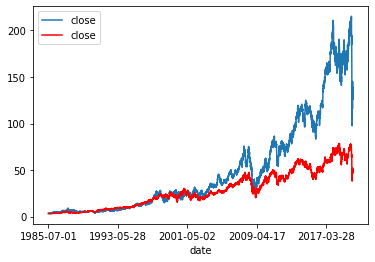

In [439]:

ax = first_stock_df.plot(y='close')
second_stock_df.plot(y='close', color='red', ax=ax)

In [440]:
n_rows = len(first_stock_df)
n_days_stride = 365

previous_row = 0
c = 0

correlation_per_time_period = defaultdict(list)
for day_window in range(n_rows):
    
    if day_window % 100 == 0:
        print(f"Idx {day_window} out of {n_rows}")
    first_stock= first_stock_df.iloc[previous_row:day_window + n_days_stride, :]
    second_stock = second_stock_df.iloc[previous_row:day_window + n_days_stride, :]
#     print(f"Correcoef for {first_stock.index.min()} to {second_stock.index.max()}")
    correlation = np.corrcoef(first_stock.close, second_stock.close)[0,1]

#     print(correlation) 
    
    correlation_per_time_period['date'].append(first_stock.index.min())
    correlation_per_time_period['correlation'].append(correlation)
    
    previous_row+= 1

    
    

Idx 0 out of 8770
Idx 100 out of 8770
Idx 200 out of 8770
Idx 300 out of 8770
Idx 400 out of 8770
Idx 500 out of 8770
Idx 600 out of 8770
Idx 700 out of 8770
Idx 800 out of 8770
Idx 900 out of 8770
Idx 1000 out of 8770
Idx 1100 out of 8770
Idx 1200 out of 8770
Idx 1300 out of 8770
Idx 1400 out of 8770
Idx 1500 out of 8770
Idx 1600 out of 8770
Idx 1700 out of 8770
Idx 1800 out of 8770
Idx 1900 out of 8770
Idx 2000 out of 8770
Idx 2100 out of 8770
Idx 2200 out of 8770
Idx 2300 out of 8770
Idx 2400 out of 8770
Idx 2500 out of 8770
Idx 2600 out of 8770
Idx 2700 out of 8770
Idx 2800 out of 8770
Idx 2900 out of 8770
Idx 3000 out of 8770
Idx 3100 out of 8770
Idx 3200 out of 8770
Idx 3300 out of 8770
Idx 3400 out of 8770
Idx 3500 out of 8770
Idx 3600 out of 8770
Idx 3700 out of 8770
Idx 3800 out of 8770
Idx 3900 out of 8770
Idx 4000 out of 8770
Idx 4100 out of 8770
Idx 4200 out of 8770
Idx 4300 out of 8770
Idx 4400 out of 8770
Idx 4500 out of 8770
Idx 4600 out of 8770
Idx 4700 out of 8770
Idx 

/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [443]:
correlation_df = pd.DataFrame(correlation_per_time_period)
correlation_df.set_index('date')

,correlation
date,
1985-07-01,0.908957
1985-07-02,0.908344
1985-07-03,0.908069
1985-07-05,0.907743
1985-07-08,0.907586
...,...
2020-04-13,0.936544
2020-04-14,0.965812
2020-04-15,0.970104


In [444]:
correlation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8770 entries, 0 to 8769
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         8770 non-null   object 
 1   correlation  8769 non-null   float64
dtypes: float64(1), object(1)
memory usage: 137.2+ KB


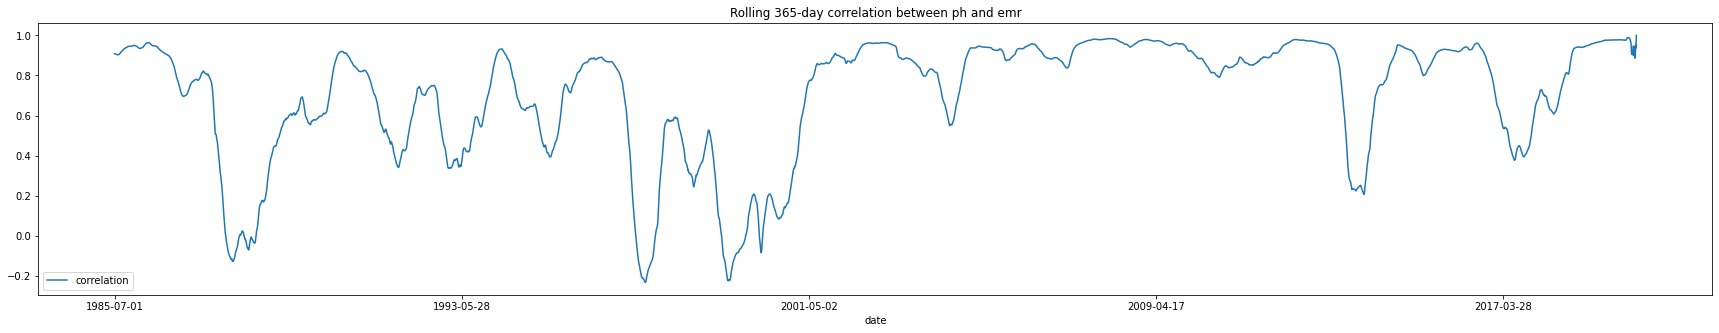

In [445]:
correlation_df.set_index('date').plot(figsize=(30,5), title='Rolling 365-day correlation between ph and emr')

In [446]:
correlation_df.date.max()

'2020-04-17'

In [447]:
correlation_df.rolling(7).sum()

,correlation
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
8765,6.469109
8766,6.508580
8767,6.539512
8768,6.653166


In [448]:
correlation_df

,date,correlation
0,1985-07-01,0.908957
1,1985-07-02,0.908344
2,1985-07-03,0.908069
3,1985-07-05,0.907743
4,1985-07-08,0.907586
...,...,...
8765,2020-04-13,0.936544
8766,2020-04-14,0.965812
8767,2020-04-15,0.970104
8768,2020-04-16,1.000000


## Build a function to create correlation features for all pairs of stocks

In [771]:
def build_correlation_dfs(dict_of_stocks_and_dfs, n_day_rolling_features_list=[ 3, 6, 7, 30, 90, 180]):
    """
    Create correlation + variance based  upon daily closing stock prices for given date ranges
    
    also include daily volume
    
    We are trying to  predict 7 day correaltion
    """

    stock_features_dict = defaultdict(pd.DataFrame)
    start_time = time.time()
    
    start = time.time()
    n_stocks = len(dict_of_stocks_and_dfs.keys())
    final_feature_df = create_date_dummy_df()
    pairs_of_stocks = []
    
    for idx, first_stock_name in enumerate(dict_of_stocks_and_dfs.keys()):
        print('')
        print(f"Finished {idx/n_stocks} pct of stocks")
        print('')
        for second_idx, second_stock_name in enumerate(dict_of_stocks_and_dfs.keys()):
            if first_stock_name == second_stock_name:
                continue
            pairs_of_stocks.append(f"{first_stock_name}_{second_stock_name}")
            print('-------')
            print(f"{first_stock_name} & {second_stock_name}")
            print('-------')
            
            # here the date is not the index, yet
            first_stock_df = dict_of_stocks_and_dfs[f"{first_stock_name}"].loc[ 
                dict_of_stocks_and_dfs[f"{first_stock_name}"].date.isin(dict_of_stocks_and_dfs[f"{second_stock_name}"].date), :]
#             first_stock_df.date = pd.to_datetime(first_stock_df)
            #  filter second df by the dates in first

            # here the date is not the index, yet
            second_stock_df = dict_of_stocks_and_dfs[f"{second_stock_name}"].loc[ 
                dict_of_stocks_and_dfs[f"{second_stock_name}"].date.isin(dict_of_stocks_and_dfs[f"{first_stock_name}"].date), :]
#             second_stock_df.date = pd.to_datetime(second_stock_df)

            # set the date as an index and sort by date
            first_stock_df = first_stock_df.sort_values('date')
            second_stock_df = second_stock_df.sort_values('date')

            first_stock_df = first_stock_df.set_index('date')
            second_stock_df = second_stock_df.set_index('date')
            
            all_features_df = pd.DataFrame()
            for rolling_idx, rolling_day in enumerate(n_day_rolling_features_list):
                print('rolling_idx', rolling_idx)
                features_df = create_correlation_and_variance_features(
                    first_stock_df, second_stock_df, rolling_day, first_stock_name=first_stock_name, second_stock_name=second_stock_name)
                 
#                 if rolling_idx == 0: # only add in volume features once
#                 if f"{first_stock_name}_volume" in    

                if (f"{first_stock_name}_volume" not in features_df.columns) and (rolling_idx == 0):
                    print('adding first stock volume')
                    features_df[f"{first_stock_name}_volume"] = list(first_stock_df.volume)
                
                if (f"{second_stock_name}_volume" not in features_df.columns) and (rolling_idx == 0):
                    print('adding second stock volume')
                    features_df[f"{second_stock_name}_volume"] = list(second_stock_df.volume)
                    
                if rolling_idx == 0: 
                    print('features_df', features_df.head())
                    print('rolling idx == 0')
                    all_features_df = features_df
                else:
                    print(all_features_df.info(), 'alal features')
                    print(features_df.info(), 'features_df df')
                    all_features_df = all_features_df.join(features_df, on='date', lsuffix='_left')
                    
            all_features_df.index = pd.to_datetime(all_features_df.index)
            final_feature_df = final_feature_df.join(all_features_df, on='date')
            print('all_features_df', all_features_df.head())

#                     final_df.join(all_features_df)
        
#             stock_features_dict[f"{first_stock_name}_and_{second_stock_name}"] = all_features_df
            
            end = time.time()
            print(f"Building all features took {(end-start)/60} minutes")
            start = time.time()
            break
        
        break

    end_time = time.time()
    print(f"Total time {(end_time-start_time) / 60} minutes")
    return final_feature_df, pairs_of_stocks
            
        

# Note: will eventuall need to add in 0s for stocks withour correlation data with other stocks due to date range

In [772]:
def create_date_dummy_df(start_date=datetime.datetime(1980,1,1), n_years=55):
    
    #  create dummy df with dates to join against
    list_of_dates  = []
    n_days = 365*n_years
    start_date = datetime.datetime(1970,1,1)

    for i in range(n_days):
        list_of_dates.append(start_date + datetime.timedelta(i))
    df_ = pd.DataFrame(list_of_dates, columns=['date'])
    
    df_.date_ =  pd.to_datetime(df_.date)
    return df_.set_index('date')
    

In [773]:
def create_correlation_and_variance_features(first_stock_df, second_stock_df, n_days_stride, 
                                             first_stock_name=None, second_stock_name=None):
    """
    n_days_stride: the  number of rolling days to calculate correlation for
    """
    n_rows = len(first_stock_df)

    previous_row = 0

    features_per_time_period = defaultdict(list)
    print(f"Creating correlations + variance on close for {n_days_stride} days")
    
    rolling_close_df = pd.DataFrame(first_stock_df.close.rolling(
        n_days_stride).corr(second_stock_df.close)).rename(
        {'close': f"{first_stock_name}_{second_stock_name}_close_corr_rolling_{n_days_stride}_days"},axis=1).fillna(method='backfill').round(6)

    
    rolling_close_std_first_stock =  first_stock_df.close.rolling(n_days_stride).std().fillna(method='backfill')
    rolling_close_std_second_stock =  second_stock_df.close.rolling(n_days_stride).std().fillna(method='backfill')
    
    rolling_volume_std_first_stock =  first_stock_df.volume.rolling(n_days_stride).std().fillna(method='backfill')
    rolling_volume_std_second_stock =  second_stock_df.volume.rolling(n_days_stride).std().fillna(method='backfill')
    # add cols
    rolling_close_df[f"{first_stock_name}_close_std_rolling_{n_days_stride}_days"] = rolling_close_std_first_stock
    rolling_close_df[f"{second_stock_name}_close_std_rolling_{n_days_stride}_days"] = rolling_close_std_second_stock

    rolling_close_df[f"{first_stock_name}_volume_std_rolling_{n_days_stride}_days"] = rolling_volume_std_first_stock
    rolling_close_df[f"{second_stock_name}_volume_std_rolling_{n_days_stride}_days"] = rolling_volume_std_second_stock
    
    return rolling_close_df



In [774]:
# 100 minutes for 20 stocks (20*20 = 400 pairs each pair takes .25 minutes)
final_stock_df, pairs_of_stocks = build_correlation_dfs(dict_of_stocks_and_dfs)

/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if sys.path[0] == '':



Finished 0.0 pct of stocks

-------
pnr & bac
-------
rolling_idx 0
Creating correlations + variance on close for 3 days
adding first stock volume
adding second stock volume
features_df             pnr_bac_close_corr_rolling_3_days  pnr_close_std_rolling_3_days  \
date                                                                          
2005-02-25                          -0.978919                      0.141000   
2005-02-28                          -0.978919                      0.141000   
2005-03-01                          -0.978919                      0.141000   
2005-03-02                          -0.985118                      0.160553   
2005-03-03                          -0.998760                      0.217682   

            bac_close_std_rolling_3_days  pnr_volume_std_rolling_3_days  \
date                                                                      
2005-02-25                      0.206350                   34297.951693   
2005-02-28                      0.

In [775]:
pairs_of_stocks

['pnr_bac']

In [776]:
final_stock_df.loc[~pd.isna(final_stock_df.pnr_volume), :]

,pnr_bac_close_corr_rolling_3_days,pnr_close_std_rolling_3_days,bac_close_std_rolling_3_days,pnr_volume_std_rolling_3_days,bac_volume_std_rolling_3_days,pnr_volume,bac_volume,pnr_bac_close_corr_rolling_6_days,pnr_close_std_rolling_6_days,bac_close_std_rolling_6_days,...,pnr_bac_close_corr_rolling_90_days,pnr_close_std_rolling_90_days,bac_close_std_rolling_90_days,pnr_volume_std_rolling_90_days,bac_volume_std_rolling_90_days,pnr_bac_close_corr_rolling_180_days,pnr_close_std_rolling_180_days,bac_close_std_rolling_180_days,pnr_volume_std_rolling_180_days,bac_volume_std_rolling_180_days
date,,,,,,,,,,,,,,,,,,,,,
2005-02-25,-0.978919,0.141000,0.206350,34297.951693,1.350538e+06,425379.0,8656470.0,-0.299410,0.324757,0.235476,...,0.815321,1.856808,0.886855,383698.536801,5.767055e+06,0.758490,2.961731,1.416882,853412.699352,5.156249e+06
2005-02-28,-0.978919,0.141000,0.206350,34297.951693,1.350538e+06,489224.0,10653157.0,-0.299410,0.324757,0.235476,...,0.815321,1.856808,0.886855,383698.536801,5.767055e+06,0.758490,2.961731,1.416882,853412.699352,5.156249e+06
2005-03-01,-0.978919,0.141000,0.206350,34297.951693,1.350538e+06,479025.0,11230182.0,-0.299410,0.324757,0.235476,...,0.815321,1.856808,0.886855,383698.536801,5.767055e+06,0.758490,2.961731,1.416882,853412.699352,5.156249e+06
2005-03-02,-0.985118,0.160553,0.258003,15394.968236,4.720071e+05,458965.0,10294635.0,-0.299410,0.324757,0.235476,...,0.815321,1.856808,0.886855,383698.536801,5.767055e+06,0.758490,2.961731,1.416882,853412.699352,5.156249e+06
2005-03-03,-0.998760,0.217682,0.359674,70107.715840,7.917529e+05,589176.0,9655981.0,-0.299410,0.324757,0.235476,...,0.815321,1.856808,0.886855,383698.536801,5.767055e+06,0.758490,2.961731,1.416882,853412.699352,5.156249e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-13,0.285322,0.757166,0.717937,302410.058942,2.497579e+07,806105.0,83164717.0,0.899761,1.619308,1.780286,...,0.967225,6.933593,5.763786,543880.332573,4.143010e+07,0.960213,5.392086,4.354907,509706.391049,3.355659e+07
2020-04-14,0.744225,0.690869,0.605062,328987.136047,2.289724e+07,1355716.0,88991066.0,0.812464,0.809988,1.265155,...,0.967615,6.979617,5.797927,543964.834769,4.144354e+07,0.960794,5.420414,4.380149,509749.853016,3.359015e+07
2020-04-15,0.669138,0.557704,0.948736,743926.304548,8.053413e+06,2278293.0,99082222.0,0.763178,0.742662,1.054806,...,0.968141,7.035977,5.849347,553951.174431,4.144466e+07,0.961412,5.457010,4.418814,513459.779923,3.364651e+07


In [777]:
final_stock_df.loc[~pd.isna(final_stock_df.pnr_volume), :]

,pnr_bac_close_corr_rolling_3_days,pnr_close_std_rolling_3_days,bac_close_std_rolling_3_days,pnr_volume_std_rolling_3_days,bac_volume_std_rolling_3_days,pnr_volume,bac_volume,pnr_bac_close_corr_rolling_6_days,pnr_close_std_rolling_6_days,bac_close_std_rolling_6_days,...,pnr_bac_close_corr_rolling_90_days,pnr_close_std_rolling_90_days,bac_close_std_rolling_90_days,pnr_volume_std_rolling_90_days,bac_volume_std_rolling_90_days,pnr_bac_close_corr_rolling_180_days,pnr_close_std_rolling_180_days,bac_close_std_rolling_180_days,pnr_volume_std_rolling_180_days,bac_volume_std_rolling_180_days
date,,,,,,,,,,,,,,,,,,,,,
2005-02-25,-0.978919,0.141000,0.206350,34297.951693,1.350538e+06,425379.0,8656470.0,-0.299410,0.324757,0.235476,...,0.815321,1.856808,0.886855,383698.536801,5.767055e+06,0.758490,2.961731,1.416882,853412.699352,5.156249e+06
2005-02-28,-0.978919,0.141000,0.206350,34297.951693,1.350538e+06,489224.0,10653157.0,-0.299410,0.324757,0.235476,...,0.815321,1.856808,0.886855,383698.536801,5.767055e+06,0.758490,2.961731,1.416882,853412.699352,5.156249e+06
2005-03-01,-0.978919,0.141000,0.206350,34297.951693,1.350538e+06,479025.0,11230182.0,-0.299410,0.324757,0.235476,...,0.815321,1.856808,0.886855,383698.536801,5.767055e+06,0.758490,2.961731,1.416882,853412.699352,5.156249e+06
2005-03-02,-0.985118,0.160553,0.258003,15394.968236,4.720071e+05,458965.0,10294635.0,-0.299410,0.324757,0.235476,...,0.815321,1.856808,0.886855,383698.536801,5.767055e+06,0.758490,2.961731,1.416882,853412.699352,5.156249e+06
2005-03-03,-0.998760,0.217682,0.359674,70107.715840,7.917529e+05,589176.0,9655981.0,-0.299410,0.324757,0.235476,...,0.815321,1.856808,0.886855,383698.536801,5.767055e+06,0.758490,2.961731,1.416882,853412.699352,5.156249e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-13,0.285322,0.757166,0.717937,302410.058942,2.497579e+07,806105.0,83164717.0,0.899761,1.619308,1.780286,...,0.967225,6.933593,5.763786,543880.332573,4.143010e+07,0.960213,5.392086,4.354907,509706.391049,3.355659e+07
2020-04-14,0.744225,0.690869,0.605062,328987.136047,2.289724e+07,1355716.0,88991066.0,0.812464,0.809988,1.265155,...,0.967615,6.979617,5.797927,543964.834769,4.144354e+07,0.960794,5.420414,4.380149,509749.853016,3.359015e+07
2020-04-15,0.669138,0.557704,0.948736,743926.304548,8.053413e+06,2278293.0,99082222.0,0.763178,0.742662,1.054806,...,0.968141,7.035977,5.849347,553951.174431,4.144466e+07,0.961412,5.457010,4.418814,513459.779923,3.364651e+07


In [778]:
final_stock_df[['pnr_bac_close_corr_rolling_365_days','pnr_bac_close_corr_rolling_180_days', 
                                                'pnr_bac_close_corr_rolling_30_days']].plot(figsize=(15,5))

KeyError: "['pnr_bac_close_corr_rolling_365_days'] not in index"

In [748]:
final_stock_df.columns

Index(['pnr_bac_close_corr_rolling_3_days', 'pnr_close_std_rolling_3_days',
       'bac_close_std_rolling_3_days', 'pnr_volume_std_rolling_3_days',
       'bac_volume_std_rolling_3_days', 'pnr_volume', 'bac_volume',
       'pnr_bac_close_corr_rolling_5_days', 'pnr_close_std_rolling_5_days',
       'bac_close_std_rolling_5_days', 'pnr_volume_std_rolling_5_days',
       'bac_volume_std_rolling_5_days', 'pnr_bac_close_corr_rolling_7_days',
       'pnr_close_std_rolling_7_days', 'bac_close_std_rolling_7_days',
       'pnr_volume_std_rolling_7_days', 'bac_volume_std_rolling_7_days',
       'pnr_bac_close_corr_rolling_30_days', 'pnr_close_std_rolling_30_days',
       'bac_close_std_rolling_30_days', 'pnr_volume_std_rolling_30_days',
       'bac_volume_std_rolling_30_days', 'pnr_bac_close_corr_rolling_180_days',
       'pnr_close_std_rolling_180_days', 'bac_close_std_rolling_180_days',
       'pnr_volume_std_rolling_180_days', 'bac_volume_std_rolling_180_days',
       'pnr_bac_close_corr_roll

## Train Test Split to predict correlation over the next 7 days
- rolling evey day make a predictions about what the correlation will be for the next 7 days stock price

In [749]:
datetime.timedelta(7)

datetime.timedelta(days=7)

- Create time based features

In [750]:
days = [i.day for i in final_stock_df.index]
months = [i.month for i in final_stock_df.index]
quarters = [i.quarter for i in final_stock_df.index]
years = [i.year for i in final_stock_df.index]

final_stock_df['day'] = days
final_stock_df['month'] = months
final_stock_df['quarter'] = quarters
final_stock_df['year'] = years

In [751]:
final_stock_df.head()

,pnr_bac_close_corr_rolling_3_days,pnr_close_std_rolling_3_days,bac_close_std_rolling_3_days,pnr_volume_std_rolling_3_days,bac_volume_std_rolling_3_days,pnr_volume,bac_volume,pnr_bac_close_corr_rolling_5_days,pnr_close_std_rolling_5_days,bac_close_std_rolling_5_days,...,bac_volume_std_rolling_180_days,pnr_bac_close_corr_rolling_365_days,pnr_close_std_rolling_365_days,bac_close_std_rolling_365_days,pnr_volume_std_rolling_365_days,bac_volume_std_rolling_365_days,day,month,quarter,year
date,,,,,,,,,,,,,,,,,,,,,
1970-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1970
1970-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,1,1,1970
1970-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,1,1970
1970-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4,1,1,1970
1970-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5,1,1,1970


- Rolling Predictions

In [752]:
# drop na
final_stock_df = final_stock_df.dropna()

In [753]:
final_stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3811 entries, 2005-02-25 to 2020-04-17
Data columns (total 36 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   pnr_bac_close_corr_rolling_3_days    3811 non-null   float64
 1   pnr_close_std_rolling_3_days         3811 non-null   float64
 2   bac_close_std_rolling_3_days         3811 non-null   float64
 3   pnr_volume_std_rolling_3_days        3811 non-null   float64
 4   bac_volume_std_rolling_3_days        3811 non-null   float64
 5   pnr_volume                           3811 non-null   float64
 6   bac_volume                           3811 non-null   float64
 7   pnr_bac_close_corr_rolling_5_days    3811 non-null   float64
 8   pnr_close_std_rolling_5_days         3811 non-null   float64
 9   bac_close_std_rolling_5_days         3811 non-null   float64
 10  pnr_volume_std_rolling_5_days        3811 non-null   float64
 11  bac_volume_s

In [755]:
rolling_window = 7
predicted_corr_7_days = []
actual = []
rmse_corr_7_days = []
prediction_date = []

print_idx = 100
starting_date_index= 3500 # otherwise, takes too long
start = time.time()

final_row = None
for date_idx, date in enumerate(list(final_stock_df.index)[starting_date_index:]):
#     print((date_id x+ starting_date_index+rolling_window+1))
#     print(len(final_stock_df))
    
    if final_row:
        break
    if (date_idx + starting_date_index +rolling_window +1) == len(final_stock_df): # last row
        final_row = True
        # need to use the dates from the DF due to weekends
        train_dates = final_stock_df.index[:starting_date_index+date_idx]
        # The test is the rolling 7-day corr looking back the past seven days
        # Therefore, the test_date should be seven dates ahead of the data we are training on

        test_date = final_stock_df.index[starting_date_index+rolling_window+date_idx]
        
    else:
        # need to use the dates from the DF due to weekends
        train_dates = final_stock_df.index[:starting_date_index+date_idx+1]
        # The test is the rolling 7-day corr looking back the past seven days
        # Therefore, the test_date should be seven dates ahead of the data we are training on

        test_date = final_stock_df.index[starting_date_index+rolling_window+date_idx+1]
    
    
    prediction_date.append(test_date)
    
    if date_idx % print_idx == 0:
        print(f"Train dates =  {train_dates}")
        print(F"Prediction date = {test_date}")
        
    train_df = final_stock_df[final_stock_df.index.isin(list(train_dates))]
    test_df = final_stock_df[final_stock_df.index == test_date]
    
    # TODO - search for the rolling 7-days column, don't hardcode
    X_train, y_train = train_df.loc[:, train_df.columns != 'pnr_bac_close_corr_rolling_7_days'],  train_df.pnr_bac_close_corr_rolling_7_days
    X_test, y_test = test_df.loc[:, test_df.columns != 'pnr_bac_close_corr_rolling_7_days'],  test_df.pnr_bac_close_corr_rolling_7_days

#     gb = GradientBoostingRegressor()
    rf = RandomForestRegressor(n_jobs=-1)

    X_train = np.nan_to_num(X_train.astype(np.float32)) # converting to float 32 throws some infinity errors
    rf.fit(X_train, y_train)

    prediction = rf.predict(X_test)

    predicted_corr_7_days.append(prediction[0])
    actual.append(y_test.values[0])
    
    rmse_corr_7_days.append(np.sqrt(mean_squared_error(y_test, prediction)))
    if date_idx % print_idx == 0:
        print('prediction = ', prediction)
        print('actual =', y_test.values)
        print('')
    

end = time.time()

print(f"Predictions took {(end-start)/60} minutes")

Train dates =  DatetimeIndex(['2005-02-25', '2005-02-28', '2005-03-01', '2005-03-02',
               '2005-03-03', '2005-03-04', '2005-03-07', '2005-03-08',
               '2005-03-09', '2005-03-10',
               ...
               '2019-01-10', '2019-01-11', '2019-01-14', '2019-01-15',
               '2019-01-16', '2019-01-17', '2019-01-18', '2019-01-22',
               '2019-01-23', '2019-01-24'],
              dtype='datetime64[ns]', name='date', length=3501, freq=None)
Prediction date = 2019-02-05 00:00:00
prediction =  [0.42138491]
actual = [-0.606127]

Train dates =  DatetimeIndex(['2005-02-25', '2005-02-28', '2005-03-01', '2005-03-02',
               '2005-03-03', '2005-03-04', '2005-03-07', '2005-03-08',
               '2005-03-09', '2005-03-10',
               ...
               '2019-06-05', '2019-06-06', '2019-06-07', '2019-06-10',
               '2019-06-11', '2019-06-12', '2019-06-13', '2019-06-14',
               '2019-06-17', '2019-06-18'],
              dtype='datetim

In [756]:
np.mean(rmse_corr_7_days)

0.21447151296988917

In [707]:
np.mean(rmse_corr_7_days)

0.27645221273913956

In [689]:
np.mean(rmse_corr_7_days)

0.299352551057616

In [757]:
prediction_df = pd.DataFrame( {'actual_corr_7_days':actual, 'predicted_corr_7_days': predicted_corr_7_days, 'prediction_date':prediction_date})

In [758]:
prediction_df = prediction_df.set_index('prediction_date')

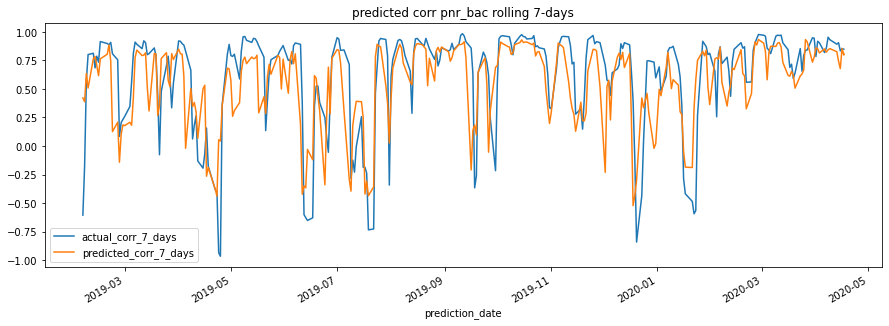

In [759]:
prediction_df.plot(title='predicted corr pnr_bac rolling 7-days', figsize=(15,5))

In [510]:
prediction_df.index

DatetimeIndex(['2019-11-20', '2019-11-21', '2019-11-22', '2019-11-25',
               '2019-11-26', '2019-11-27', '2019-11-29', '2019-12-02',
               '2019-12-03', '2019-12-04',
               ...
               '2020-04-03', '2020-04-06', '2020-04-07', '2020-04-08',
               '2020-04-09', '2020-04-13', '2020-04-14', '2020-04-15',
               '2020-04-16', '2020-04-16'],
              dtype='datetime64[ns]', name='prediction_date', length=102, freq=None)

## Feature Importances
- nit: only based on last tree fit

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]),
 <a list of 35 Text major ticklabel objects>)

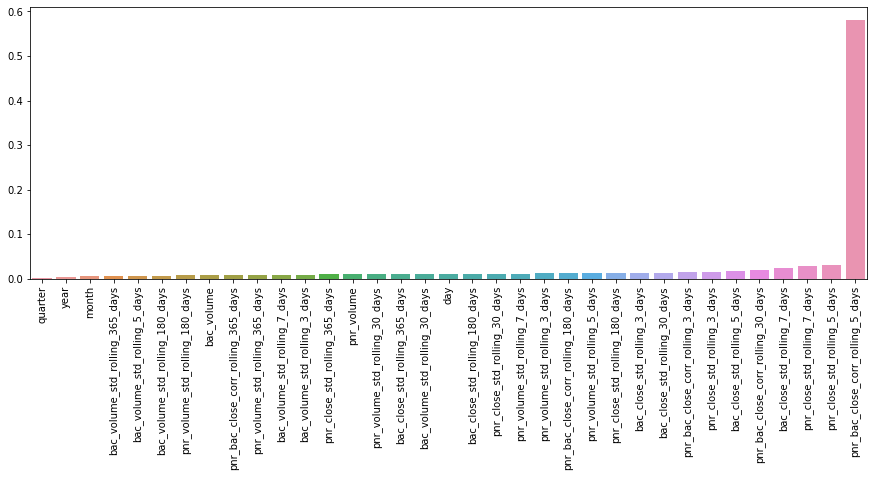

In [770]:
cols = list(final_stock_df.columns)
cols.remove('pnr_bac_close_corr_rolling_7_days')

plt.figure(figsize=(15,5))
sns.barplot(x=np.array(cols)[np.argsort(rf.feature_importances_)], y=rf.feature_importances_[np.argsort(rf.feature_importances_)])
plt.xticks(rotation=90)

In [764]:
for col, importance in zip(final_stock_df.columns, rf.feature_importances_):
    print(f"Feature {col}")
    print(f"Importance {importance}")
    print()

Feature pnr_bac_close_corr_rolling_3_days
Importance 0.015094793495532137

Feature pnr_close_std_rolling_3_days
Importance 0.016182135381867496

Feature bac_close_std_rolling_3_days
Importance 0.013289012009281528

Feature pnr_volume_std_rolling_3_days
Importance 0.01221490127807399

Feature bac_volume_std_rolling_3_days
Importance 0.009923936109575529

Feature pnr_volume
Importance 0.010649166400772878

Feature bac_volume
Importance 0.0090601933115144

Feature pnr_bac_close_corr_rolling_5_days
Importance 0.5807661743325525

Feature pnr_close_std_rolling_5_days
Importance 0.031263364845366313

Feature bac_close_std_rolling_5_days
Importance 0.01783157096446582

Feature pnr_volume_std_rolling_5_days
Importance 0.012737413494054734

Feature bac_volume_std_rolling_5_days
Importance 0.006765321044079531

Feature pnr_bac_close_corr_rolling_7_days
Importance 0.029206110314775043

Feature pnr_close_std_rolling_7_days
Importance 0.024192409325110225

Feature bac_close_std_rolling_7_days
Import